In [ ]:
# Noise Scheduler

import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

T = 400 # This value can be changed.


def linear_beta_schedule(steps, start = 0.0001, end = 0.02)
    return torch.linspace(start, end, steps)

def get_index_from_list(values, t, x_shape): 
    batch_size = t.shape[0]
    out = values.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):

    
    betas = linear_beta_schedule(steps = T)


    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

   
    noise = torch.randn_like(x_0)
    sqrt_alphas_cummulativeproduct_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)



In [2]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np

# Importing torch libraries.

image_size = 64
batch_size = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]

    data_transform = transforms.Compose(data_transforms)

    dataset = datasets.CelebA(root = r"C:\Users\huds0\Desktop\research\celeba", download = True, transform = data_transform)

    return dataset


def to_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

     # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)



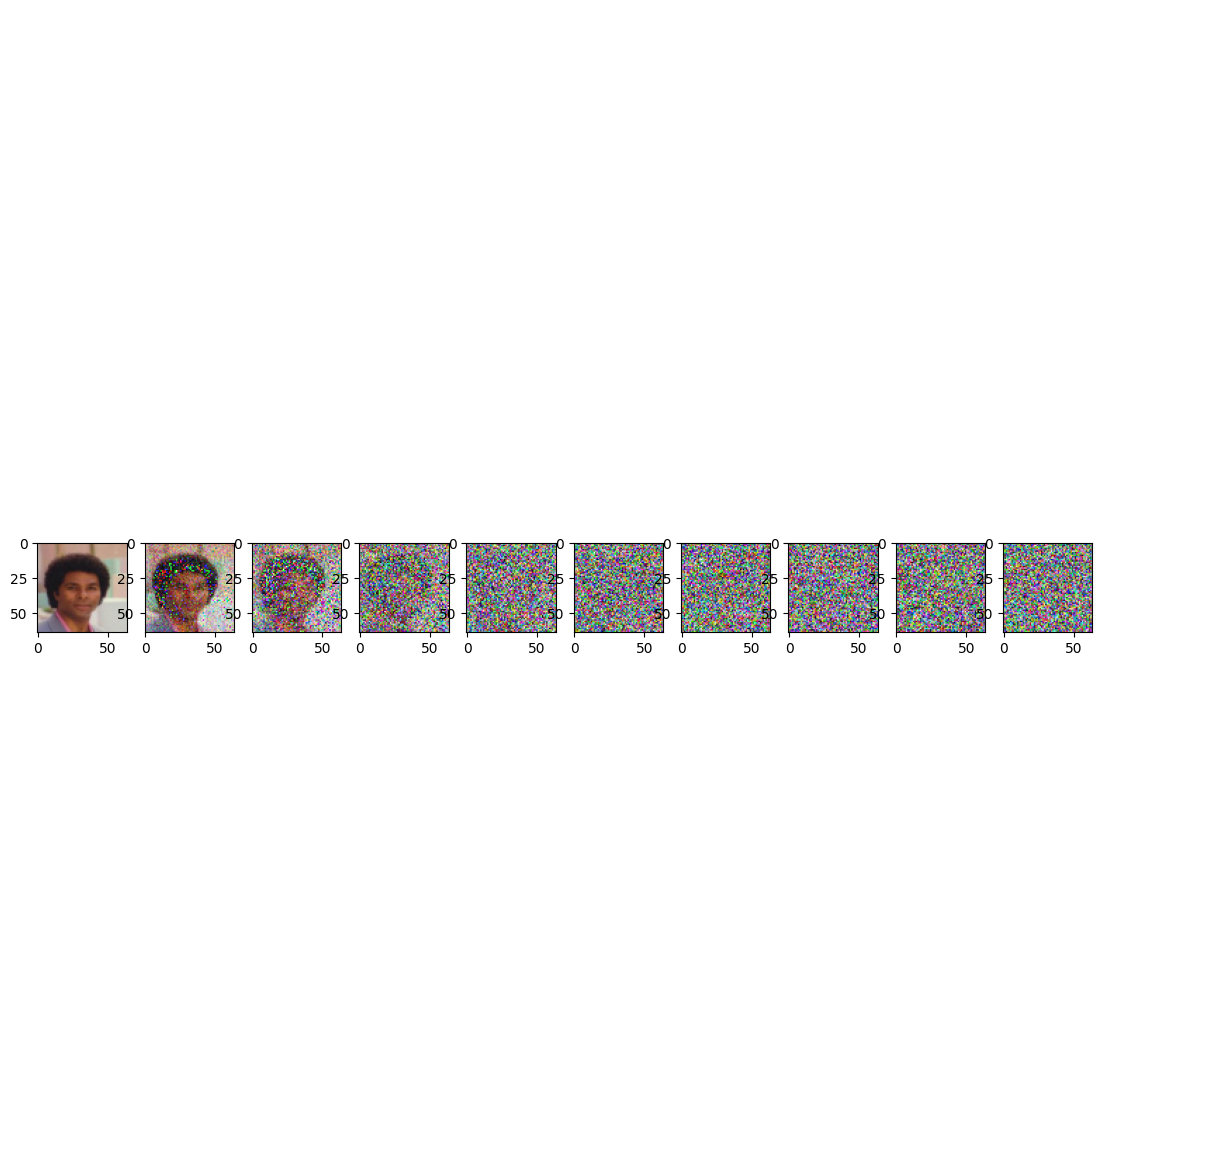

In [3]:
# Actual run it let's go.

image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    to_tensor_image(img)